In [6]:
# !pip install timm
# !pip install einops
# !pip install spectral
# !pip install plotly
# !pip install pandas
# !pip install seaborn
# !pip install scikit-image
# !pip install opencv-python
# !pip install thop
# !pip install scikit-learn

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from einops import rearrange

import torch.nn.init as init

In [16]:
def _weights_init(m):
  classname = m.__class__.__name
  if isinstance(m,nn.Linear) or isinstance(m,nn.Conv3d):
    init.kaiming_normal(m.weight)
class Residual(nn.Module):
  def __init__(self,fn):
    super().init__()
    self.fn = fn

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x
# 等于 PreNorm
class LayerNormalize(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
# 等于 FeedForward
class MLP_Block(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=12, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.to_qkv = nn.Linear(dim,dim*3,bias=True)
        self.nn1 = nn.Linear(dim,dim)
        self.do1 = nn.Dropout(dropout)

        self.act = nn.GELU()
        self.sr1 = nn.Conv2d(dim, dim, kernel_size=4, stride=4)
        self.norm1 = nn.LayerNorm(dim)
        self.sr2 = nn.Conv2d(dim, dim, kernel_size=2, stride=2)
        self.norm2 = nn.LayerNorm(dim)
        self.kv1 = nn.Linear(dim, dim, bias=False)
        self.kv2 = nn.Linear(dim, dim, bias=False)
        self.attn_drop = nn.Dropout(0.)
        self.local_conv1 = nn.Conv2d(dim//2, dim//2, kernel_size=3, padding=1, stride=1, groups=dim//2)
        self.local_conv2 = nn.Conv2d(dim//2, dim//2, kernel_size=3, padding=1, stride=1, groups=dim//2)

        self.spectral_conv = nn.Conv2d(1, 1, kernel_size=3, padding=1)
        self.to_qkv_spec_8 = nn.Linear(64, 64*3, bias=False)#len_token
        self.norm3 = nn.LayerNorm(dim)

    def forward(self,x,mask=None):
      b, n, d, h = *x.shape, self.heads
      qkv = self.to_qkv(x).chunk(3,dim=-1)
      q,k,v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)# split into multi head attentions
      dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
      mask_value = -torch.finfo(dots.dtype).max
      if mask is not None:
        mask = F.pad(mask.flatten(1), (1, 0), value=True)
        assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
        mask = mask[:, None, :] * mask[:, :, None]
        dots.masked_fill_(~mask, float('-inf'))
        del mask
      attn = dots.softmax(dim=-1)
      out = torch.einsum('bhij,bhjd->bhid', attn, v)
      out = rearrange(out, 'b h n d -> b n (h d)')
      #************************************************************
      #         shunted-Attention
      #************************************************************
      x_ = x.permute(0, 2, 1).reshape(b, d, int(n**0.5), int(n**0.5))
      x_1 = self.act(self.norm1(self.sr1(x_).reshape(b, 64, -1).permute(0, 2, 1)))
      x_2 = self.act(self.norm2(self.sr2(x_).reshape(b, 64, -1).permute(0, 2, 1)))
      tip1 = self.kv1(x_1)
      tip2 = self.kv1(x_2)
      kv1 = self.kv1(x_1).reshape(b, -1, 2, h//2, 64 // h).permute(2, 0, 3, 1, 4)
      kv2 = self.kv2(x_2).reshape(b, -1, 2, h//2, 64 // h).permute(2, 0, 3, 1, 4)
      k1, v1 = kv1[0], kv1[1]
      k2, v2 = kv2[0], kv2[1]
      attn1 = (q[:, :h//2] @ k1.transpose(-2, -1)) * self.scale
      attn1 = attn1.softmax(dim=-1)
      out1 = (attn1 @ v1).transpose(1, 2).reshape(b, n, 64//2)
      attn2 = (q[:, h // 2:] @ k2.transpose(-2, -1)) * self.scale
      attn2 = attn2.softmax(dim=-1)
      out2 = (attn2 @ v2).transpose(1, 2).reshape(b, n, 64//2)
      out_b = torch.cat([out1,out2],dim=-1)
      #         Channel-Attention
      #************************************************************
      x_transpose = x.transpose(-2, -1)
      num_tokens = int(x_transpose.shape[-1])
      qkv_spec = self.to_qkv_spec_8(x_transpose).chunk(3, dim=-1)
      q_spec, k_spec, v_spec = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=1), qkv_spec)
      dots_spec = torch.matmul(q_spec, k_spec.transpose(-1, -2)) * self.scale
      attn_spec = dots_spec.softmax(dim=-1)
      attn_spec = self.spectral_conv(attn_spec)
      out_spec = (attn_spec @ v_spec).transpose(1, 2).reshape(b, n, 64)
      out = (out+out_b+self.norm3(out_spec))*0.6
      out = self.nn1(out)
      out = self.do1(out)

      return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(LayerNormalize(dim, Attention(dim, heads=heads, dropout=dropout))),
                Residual(LayerNormalize(dim, MLP_Block(dim, mlp_dim, dropout=dropout)))
            ]))
    def forward(self, x, mask=None):
        for attention, mlp in self.layers:
            x = attention(x, mask=mask)  # go to attention
            x = mlp(x)  # go to MLP_Block
        return x


#此函数用于网络初始阶段生成token
class Head_High(nn.Module):
    def __init__(self):
        super(Head_High, self).__init__()
        self.conv3d_features = nn.Sequential(
            nn.Conv3d(1, out_channels=8, kernel_size=(3, 3, 3)),
            nn.BatchNorm3d(8),
            nn.ReLU(),
        )
        self.conv2d_features = nn.Sequential(
            nn.Conv2d(in_channels=8*28, out_channels=64, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.conv2d_features_3 = nn.Sequential(
            nn.Conv2d(in_channels=8*28, out_channels=64, kernel_size=(5, 5)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        #高斯加权模块
        #................................................
        self.token_wA = nn.Parameter(torch.empty(1,60,64),requires_grad=True)# Tokenization parameters (1,4,64)
        torch.nn.init.xavier_normal_(self.token_wA)
        self.token_wV = nn.Parameter(torch.empty(1,64,64),requires_grad=True)# Tokenization parameters
        torch.nn.init.xavier_normal_(self.token_wV)

        self.token_wA_1 = nn.Parameter(torch.empty(1,60,64),requires_grad=True)# Tokenization parameters (1,4,64)
        torch.nn.init.xavier_normal_(self.token_wA_1)
        self.token_wV_1 = nn.Parameter(torch.empty(1,64,64),requires_grad=True)# Tokenization parameters
        torch.nn.init.xavier_normal_(self.token_wV_1)

        self.token_wA_2 = nn.Parameter(torch.empty(1,4,30),requires_grad=True)# Tokenization parameters (1,4,64)
        torch.nn.init.xavier_normal_(self.token_wA_2)
        self.token_wV_2 = nn.Parameter(torch.empty(1,1,64),requires_grad=True)# Tokenization parameters
        torch.nn.init.xavier_normal_(self.token_wV_2)

        #................................................
        #位置编码模块
        #................................................
        self.pos_embedding = nn.Parameter(torch.empty(1,64,64))
        torch.nn.init.normal_(self.pos_embedding, std=.02)
        #................................................
        #cls_token模块
        self.dropout_T = nn.Dropout(0.1)
        self.norm = nn.LayerNorm(64)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()
    def forward(self, x):
        x_spec = x
        x_spec = x_spec[:,:,:,8:9,8:9]
        x = self.conv3d_features(x)
        x = rearrange(x, 'b c h w y -> b (c h) w y')
        #多尺度特征
        #...................................................
        x_3d = x
        x = self.conv2d_features(x)
        x_m2 = self.conv2d_features_3(x_3d)
        #...................................................
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        #高斯加权模块1
        #................................................
        wa = rearrange(self.token_wA, 'b h w -> b w h')#生成weight matrix wa(1,64,81)
        A = torch.einsum('bij,bjk->bik', x, wa)#利用weight matrix 和 x 生成Sematic group(1,289,81)
        A = rearrange(A, 'b h w -> b w h')  # 转置Sematic group以进行SOFTMAX  (1,81,289)
        A = A.softmax(dim=-1)
        VV = torch.einsum('bij,bjk->bik', x, self.token_wV)# x(1,289,64) wV(1,64,64) VV(1,289,64)
        T = torch.einsum('bij,bjk->bik', A, VV)
        #................................................
        #高斯加权模块2
        #................................................
        #print("高斯加权模块2")
        x_m2 = x_m2.flatten(2).transpose(1, 2)
        wa1 = rearrange(self.token_wA_1, 'b h w -> b w h')#生成weight matrix wa(1,64,81)
        A1 = torch.einsum('bij,bjk->bik', x_m2, wa1)#利用weight matrix 和 x 生成Sematic group(1,289,81)
        A1 = rearrange(A1, 'b h w -> b w h')  # 转置Sematic group以进行SOFTMAX  (1,81,289)
        A1 = A1.softmax(dim=-1)
        VV1 = torch.einsum('bij,bjk->bik', x_m2, self.token_wV_1)# x(1,289,64) wV(1,64,64) VV(1,289,64)
        T1 = torch.einsum('bij,bjk->bik', A1, VV1)
        #高斯加权模块3
        #................................................
        x_spec = rearrange(x_spec,'b c h w y -> b (c h) (w y)')
        x_spec = x_spec.transpose(-1,-2)
        wa2 = rearrange(self.token_wA_2, 'b h w -> b w h')
        A2 = torch.einsum('bij,bjk->bik', x_spec, wa2)
        A2 = rearrange(A2, 'b h w -> b w h')  
        A2 = A2.softmax(dim=-1)
        T2 = torch.einsum('bij,bjk->bik', A2, self.token_wV_2)# x(1,289,64) wV(1,64,64) VV(1,289,64)
        #................................................
        #多尺度特征融合
        T = T + T1 
        T = torch.cat((T, T2), dim=1)
        #................................................
        #位置编码模块
        #...............................................
        T += self.pos_embedding
        #...............................................
        T = self.dropout_T(T)
        x = self.norm(T)
        return x
    
    
NUM_CLASS = 6
class yunxuan(nn.Module):
    def __init__(self, in_channels=1, num_classes=NUM_CLASS, num_tokens=4, dim=64, depth=1, heads=32, mlp_dim=8, dropout=0.1, emb_dropout=0.1):
      super(yunxuan, self).__init__()
      self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)
      self.nn1 = nn.Linear(dim, num_classes)
      self.Head = Head_High()
    def forward(self, x, mask=None):
      x = self.Head(x)
      x = self.transformer(x, mask)  # main game
      x = x.mean(dim=1)
      x = self.nn1(x)
      return x

In [17]:
if __name__ == '__main__':
    model = yunxuan()
    model.eval()
    input = torch.randn(1, 1, 30, 15, 15)
    y = model(input)
    print(y.size())

torch.Size([1, 6])


In [18]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [19]:
# 地物类别
class_num = 9
X = sio.loadmat('trento_data.mat')['HSI_data']
y = sio.loadmat('trento_data.mat')['ground']

# 用于测试样本的比例
test_ratio = 0.99
# 每个像素周围提取 patch 的尺寸
patch_size = 15
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape) 
print('before transpose: Xtest  shape: ', Xtest.shape) 

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape) 
print('after transpose: Xtest  shape: ', Xtest.shape) 

Hyperspectral data shape:  (166, 600, 63)
Label shape:  (166, 600)

... ... PCA tranformation ... ...
Data shape after PCA:  (166, 600, 30)

... ... create data cubes ... ...
Data cube X shape:  (30214, 15, 15, 30)
Data cube y shape:  (30214,)

... ... create train & test data ... ...
Xtrain shape:  (302, 15, 15, 30)
Xtest  shape:  (29912, 15, 15, 30)
before transpose: Xtrain shape:  (302, 15, 15, 30, 1)
before transpose: Xtest  shape:  (29912, 15, 15, 30, 1)
after transpose: Xtrain shape:  (302, 1, 30, 15, 15)
after transpose: Xtest  shape:  (29912, 1, 30, 15, 15)


In [20]:
""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=64, shuffle=False, num_workers=2)

In [21]:
def train(net):


  current_loss_his = []
  current_Acc_his = []

  best_net_wts = copy.deepcopy(net.state_dict())
  best_acc = 0.0

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  #optimizer = optim.Adam(net.parameters(), lr=0.0003)
  #step_schedule = optim.lr_scheduler.StepLR(step_size=20, gamma=0.8, optimizer=optimizer)

  # 开始训练
  total_loss = 0
  for epoch in range(100):
      net.train()  # 将模型设置为训练模式
      for i, (inputs, labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)
          # 优化器梯度归零
          optimizer.zero_grad()
          # 正向传播 +　反向传播 + 优化 
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
      #step_schedule.step()

      if epoch % 5 == 0:
        net.eval()   # 将模型设置为验证模式
        current_acc = test_acc(net)
        current_Acc_his.append(current_acc)
        print('[current acc: %.4f]' %(current_acc))

      if current_acc > best_acc:
        best_acc = current_acc
        best_net_wts = copy.deepcopy(net.state_dict())
   

      print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))
      #print('[Epoch: %d]   [learning rate: %.6f]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, step_schedule.get_last_lr()[0], total_loss/(epoch+1), loss.item()))
      current_loss_his.append(loss.item())

  print('Finished Training')
  print("Best Acc:%.4f" %(best_acc))

  # load best model weights
  net.load_state_dict(best_net_wts)

  return net,current_loss_his,current_Acc_his

In [22]:
def test_acc(net):
  count = 0
  # 模型测试
  for inputs, _ in test_loader:
      inputs = inputs.to(device)
      outputs = net(inputs)
      outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
      if count == 0:
          y_pred_test =  outputs
          count = 1
      else:
          y_pred_test = np.concatenate( (y_pred_test, outputs) )

  # 生成分类报告
  classification = classification_report(ytest, y_pred_test, digits=4)
  index_acc = classification.find('weighted avg')
  accuracy = classification[index_acc+17:index_acc+23]
  return float(accuracy)

In [23]:
import warnings
warnings.filterwarnings("ignore")
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 网络放到GPU上
net = yunxuan().to(device)
# 训练
net,current_loss_his,current_Acc_his = train(net)


[current acc: 0.5078]
[Epoch: 1]   [loss avg: 4.2798]   [current loss: 0.3518]
[Epoch: 2]   [loss avg: 2.7818]   [current loss: 0.2362]
[Epoch: 3]   [loss avg: 2.0978]   [current loss: 0.1504]
[Epoch: 4]   [loss avg: 1.7077]   [current loss: 0.0903]
[Epoch: 5]   [loss avg: 1.4243]   [current loss: 0.0375]
[current acc: 0.9797]
[Epoch: 6]   [loss avg: 1.2190]   [current loss: 0.0206]
[Epoch: 7]   [loss avg: 1.0609]   [current loss: 0.0288]
[Epoch: 8]   [loss avg: 0.9353]   [current loss: 0.0113]
[Epoch: 9]   [loss avg: 0.8353]   [current loss: 0.0060]
[Epoch: 10]   [loss avg: 0.7544]   [current loss: 0.0052]
[current acc: 0.9852]
[Epoch: 11]   [loss avg: 0.6889]   [current loss: 0.0081]
[Epoch: 12]   [loss avg: 0.6327]   [current loss: 0.0025]
[Epoch: 13]   [loss avg: 0.5851]   [current loss: 0.0025]
[Epoch: 14]   [loss avg: 0.5445]   [current loss: 0.0078]
[Epoch: 15]   [loss avg: 0.5098]   [current loss: 0.0117]
[current acc: 0.9879]
[Epoch: 16]   [loss avg: 0.4785]   [current loss: 0

              precision    recall  f1-score   support

         0.0     0.9912    0.9927    0.9920      3994
         1.0     0.9615    0.9555    0.9585      2874
         2.0     0.9948    0.7996    0.8865       474
         3.0     0.9998    0.9999    0.9998      9032
         4.0     0.9947    0.9998    0.9973     10396
         5.0     0.9496    0.9650    0.9572      3142

    accuracy                         0.9878     29912
   macro avg     0.9819    0.9521    0.9652     29912
weighted avg     0.9879    0.9878    0.9876     29912

OA:0.9877975394490506 | AA_mean:0.9520778817001401 | Kappa:0.9837074955029478


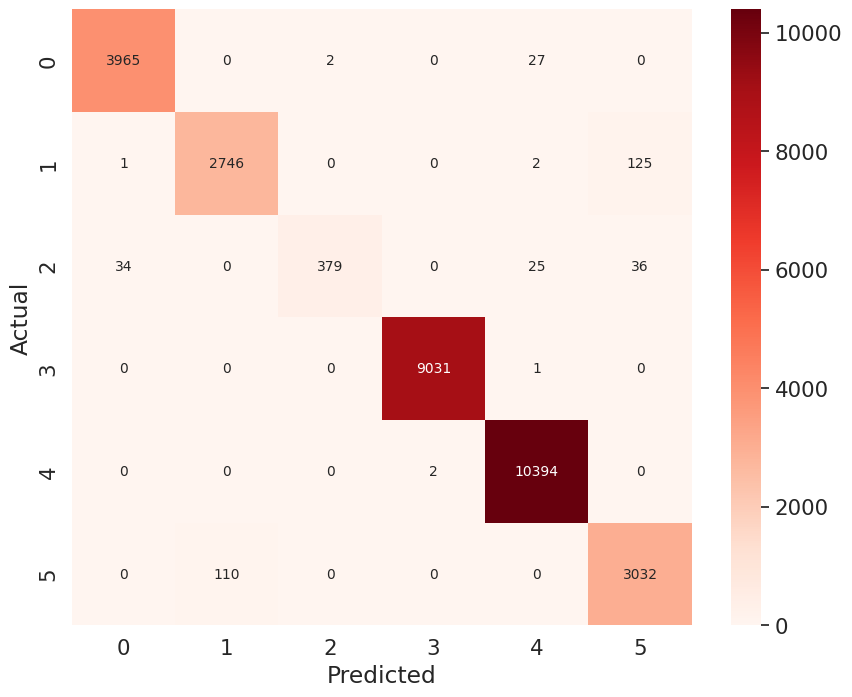

In [24]:
net.eval()   # 将模型设置为验证模式
# 测试最好的模型的结果
count = 0
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

def output_metric(tar, pre):
    matrix = confusion_matrix(ytest, y_pred_test)
    OA, AA_mean, Kappa, AA = cal_results(matrix)
    return OA, AA_mean, Kappa, AA

def cal_results(matrix):
    shape = np.shape(matrix)
    number = 0
    sum = 0
    AA = np.zeros([shape[0]], dtype=float)
    for i in range(shape[0]):
        number += matrix[i, i]
        AA[i] = matrix[i, i] / np.sum(matrix[i, :])
        sum += np.sum(matrix[i, :]) * np.sum(matrix[:, i])
    OA = number / np.sum(matrix)
    AA_mean = np.mean(AA)
    pe = sum / (np.sum(matrix) ** 2)
    Kappa = (OA - pe) / (1 - pe)
    return OA, AA_mean, Kappa, AA

OA, AA_mean, Kappa, AA = output_metric(ytest, ytest)
print("OA:{} | AA_mean:{} | Kappa:{}".format(OA,AA_mean,Kappa,))
confusion_matrix
data = confusion_matrix(ytest, y_pred_test)
df_cm = pd.DataFrame(data)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 10}, fmt='d')
plt.savefig('cmap.png', dpi=300)